In [28]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
pd.options.mode.chained_assignment = None
%config InlineBackend.figure_formats = ['svg']
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [29]:

%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [30]:
# create lists of different stats we want 
offensive_avgs = ['W', 'G', 'BA', 'OBP', 'SLG']
offensive_against_avgs = ['BA_A', 'OBP_A', 'SLG_A']
offensive_features = ['BA', 'OBP', 'SLG']
combined_features = ['BA', 'OBP', 'SLG', 
                     'BA_A', 'OBP_A', 'SLG_A']

combined_features_noba = ['OBP', 'SLG', 'OBP_A', 'SLG_A']

In [31]:
# create a df of pure stats
offense_df = pd.read_pickle("full_baseball_from_1950_df.pkl")
avgs_offense_df = offense_df[["Year", "Team", "Lg"]+offensive_avgs]

In [32]:
opponent_df = pd.read_pickle("opponents_from_1950_df.pkl")
opponent_df.rename(columns={'BA': 'BA_A', 'OBP':'OBP_A', 'SLG': 'SLG_A'}, inplace=True)
avgs_opponent_df = opponent_df[["Year", "Team"]+offensive_against_avgs]

In [33]:
full_avgs_df = pd.merge(avgs_offense_df, avgs_opponent_df, on=["Year", "Team"])

In [34]:
# grab all the seasons that have 162 games
all_games = full_avgs_df[full_avgs_df['G']==162]

In [35]:
all_games["Lg"] = all_games["Lg"].str[:2]
all_games

Year Team  Lg   W    G     BA    OBP    SLG   BA_A  OBP_A  SLG_A
1     2019  ARI  NL  85  162  0.252  0.323  0.434  0.251  0.320  0.432
2     2018  ARI  NL  82  162  0.235  0.310  0.397  0.239  0.310  0.388
3     2017  ARI  NL  93  162  0.254  0.329  0.445  0.240  0.309  0.398
4     2016  ARI  NL  69  162  0.261  0.320  0.432  0.275  0.348  0.454
5     2015  ARI  NL  79  162  0.264  0.324  0.414  0.258  0.322  0.423
...    ...  ...  ..  ..  ...    ...    ...    ...    ...    ...    ...
1765  1975  WSN  NL  75  162  0.244  0.317  0.348  0.259  0.339  0.370
1767  1973  WSN  NL  79  162  0.251  0.340  0.364  0.250  0.334  0.371
1769  1971  WSN  NL  71  162  0.246  0.322  0.343  0.261  0.341  0.388
1770  1970  WSN  NL  73  162  0.237  0.323  0.365  0.261  0.349  0.407
1771  1969  WSN  NL  52  162  0.240  0.310  0.359  0.263  0.350  0.395

[1150 rows x 11 columns]

# Lets look at coors

In [221]:
all_games[['W'] + combined_features].corr().loc[['W']]

W        BA       OBP       SLG    BA_A   OBP_A     SLG_A
W  1.0  0.399397  0.499293  0.390477 -0.5275 -0.5892 -0.440626

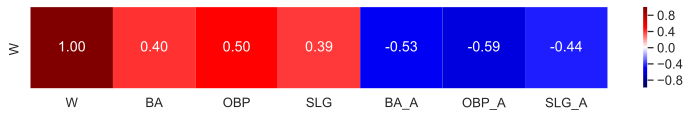

In [222]:
# plot heat map of pure stats compared to wins
f, ax = plt.subplots(figsize=(13, 1.5))
ax = sns.heatmap(all_games[['W'] + combined_features].corr().loc[['W']], cmap="seismic", annot=True, vmin=-1,  vmax=1,  fmt=".2f");

In [19]:
sns.pairplot(all_games[offensive_avgs]);

# Pure Least Squares

In [36]:
# Create an empty model
lr = LinearRegression()

features = all_games[combined_features]


# Choose the response variable
wins = all_games['W']


# Fit the model 
lr.fit(features, wins)


# Score the model (with R^2)
lr.score(features, wins)

0.8145058105657438

In [37]:
# scale the data

In [38]:
# scale the data
std = StandardScaler()
std.fit(features)
scaled_features = std.transform(features)

In [39]:
# Create an empty model
lr_scaled = LinearRegression()

# Fit the model 
lr_scaled.fit(scaled_features, wins)

# Score the model (with R^2)
lr_scaled.score(scaled_features, wins)

0.8145058105657438

In [40]:
for c in zip(combined_features, lr_scaled.coef_):
    print(c[0], c[1])

BA -0.40370600393371664
OBP 4.7620165451243555
SLG 4.9991476190483315
BA_A 0.7495856362967435
OBP_A -5.655631694045439
SLG_A -4.992809670127345


In [41]:
# obp and slugging are most important lets keep those

In [42]:
features = all_games[combined_features_noba]
std = StandardScaler()
std.fit(features)
scaled_features = std.transform(features)

In [43]:
# Create an empty model
lr_scaled = LinearRegression()

# Fit the model 
lr_scaled.fit(scaled_features, wins)

# Score the model (with R^2)
lr_scaled.score(scaled_features, wins)

0.8137754082715953

In [44]:
# barely any change, we can drop BA

In [45]:
for c in zip(combined_features_noba, lr_scaled.coef_):
    print(c[0], c[1])

OBP 4.610407408365721
SLG 4.728098792376245
OBP_A -5.278040167587238
SLG_A -4.627471405057795


# Create Function to Test model

In [214]:
def test_model(features, target):
    """
    Takes a features dataframe and a target data frame as inputs
    Returns the linear model with the score, predicted values etc 
    """
    
    # create the training and validation sets
    features, features_test, target, target_test = train_test_split(features, target, test_size=.2, random_state=10)
    features_train, features_val, target_train, target_val = train_test_split(features, target, test_size=.25, random_state=3)
    
    # set up the model and fir it with training set
    lr = LinearRegression()
    model = lr.fit(features_train, wins_train)
    
    # check the score on the validation set
    val_score = lr.score(features_val, wins_val)
    
    # run on the hold out test set
    predicted_vals = model.predict(features_test)
    
    data_dict = {
                'Score': val_score,
                'Predicted_Values': predicted_vals,
                'Target_Values': wins_test,
                'Coefficients': lr.coef_,
                'Model': model,
                'Feature_Names': features.columns
                }
    
    
    return(data_dict)
    

# Validate Model with no BA

In [223]:
# hold out 20% of the data for final testing
features = all_games[combined_features_noba]
wins = all_games['W']
features, features_test, wins, wins_test = train_test_split(features, wins, test_size=.2, random_state=8)

In [224]:
# seperate out 25% of the training set for validation
features_train, features_val, wins_train, wins_val = train_test_split(features, wins, test_size=.25, random_state=4)

In [225]:
# create the model
lr = LinearRegression()
model = lr.fit(features_train, wins_train)

In [226]:
# check the score on the validation data... it looks good
lr.score(features_val, wins_val)

0.8237248280563619

In [227]:
lr.coef_, lr.intercept_

(array([ 300.4325437 ,  150.99295828, -335.17101187, -144.46762867]),
 89.61201198650203)

In [228]:
# run the model on our test set... we can see we are off by an average of 4 wins, and 75% of our predictions are within 6 wins
test_wins = model.predict(features_test)
win_diff = test_wins - wins_test
win_diff.abs().describe()

count    230.000000
mean       3.965183
std        3.083452
min        0.031510
25%        1.506548
50%        3.197548
75%        5.820096
max       15.472112
Name: W, dtype: float64

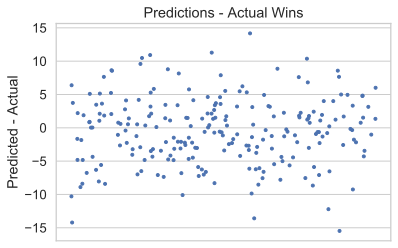

In [229]:
plt.title('Predictions - Actual Wins')
plt.xticks(ticks=[])
plt.ylabel('Predicted - Actual')
plt.plot(win_diff, '.');

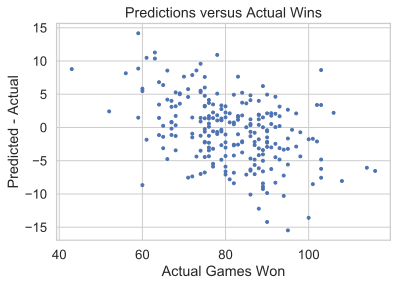

In [230]:
plt.title('Predictions versus Actual Wins')
plt.xticks()
plt.xlabel('Actual Games Won')
plt.ylabel('Predicted - Actual')
plt.plot(wins_test, win_diff, '.');

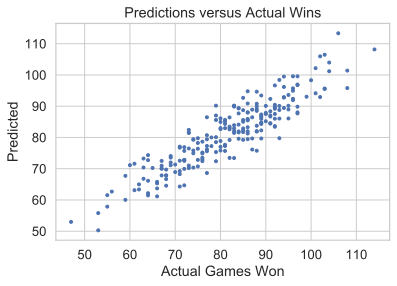

In [54]:
plt.title('Predictions versus Actual Wins')
plt.xlabel('Actual Games Won')
plt.ylabel('Predicted')
plt.plot(wins_test, test_wins, '.');

In [149]:
for c in features_test.columns:
    print(c)

OBP
SLG
OBP_A
SLG_A


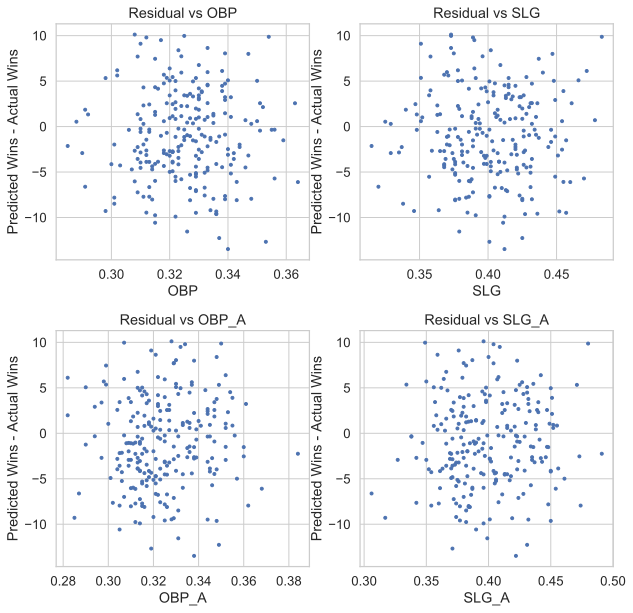

In [167]:

plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=.3)

ax1 = plt.subplot(221)
plt.title('Residual vs OBP')
plt.xticks()
plt.xlabel('OBP')
plt.ylabel('Predicted Wins - Actual Wins')
plt.plot(features_test['OBP'], win_diff, '.')

plt.subplot(222, sharey=ax1)
plt.title('Residual vs SLG')
plt.xticks()
plt.xlabel('SLG')
plt.ylabel('Predicted Wins - Actual Wins')
plt.plot(features_test['SLG'], win_diff, '.')

ax2=plt.subplot(223)
plt.title('Residual vs OBP_A')
plt.xticks()
plt.xlabel('OBP_A')
plt.ylabel('Predicted Wins - Actual Wins')
plt.plot(features_test['OBP_A'], win_diff, '.')

plt.subplot(224, sharey=ax2)
plt.title('Residual vs SLG_A')
plt.xticks()
plt.xlabel('SLG_A')
plt.ylabel('Predicted Wins - Actual Wins')
plt.plot(features_test['SLG_A'], win_diff, '.');

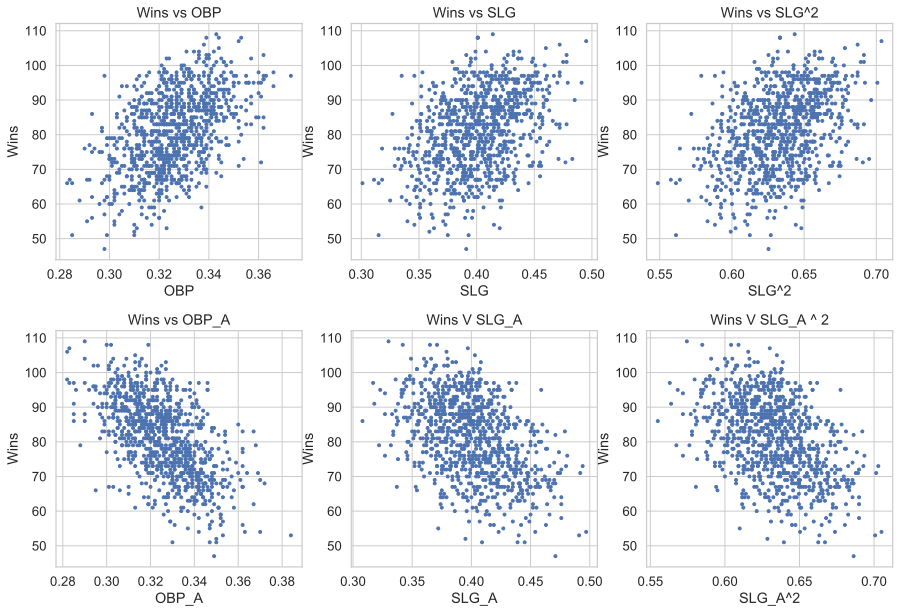

In [235]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=.3)

ax1 = plt.subplot(231)
plt.title('Wins vs OBP')
plt.xticks()
plt.xlabel('OBP')
plt.ylabel('Wins')
plt.plot(features['OBP'], wins, '.')

plt.subplot(232, sharey=ax1)
plt.title('Wins vs SLG')
plt.xticks()
plt.xlabel('SLG')
plt.ylabel('Wins')
plt.plot(features['SLG'], wins, '.')

plt.subplot(233, sharey=ax1)
plt.title('Wins vs SLG^2')
plt.xticks()
plt.xlabel('SLG^2')
plt.ylabel('Wins')
plt.plot(features['SLG']**(1/2), wins, '.')

ax2=plt.subplot(234)
plt.title('Wins vs OBP_A')
plt.xticks()
plt.xlabel('OBP_A')
plt.ylabel('Wins')
plt.plot(features['OBP_A'], wins, '.')

plt.subplot(235, sharey=ax2)
plt.title('Wins V SLG_A')
plt.xticks()
plt.xlabel('SLG_A')
plt.ylabel('Wins')
plt.plot(features['SLG_A'], wins, '.');

plt.subplot(236, sharey=ax2)
plt.title('Wins V SLG_A ^ 2')
plt.xticks()
plt.xlabel('SLG_A^2')
plt.ylabel('Wins')
plt.plot(features['SLG_A']**(1/2), wins, '.');

# Experiment no intercept

In [55]:
# create the model
lr = LinearRegression(fit_intercept = False)
model = lr.fit(features_train, wins_train)

In [56]:
lr.score(features_val, wins_val)

0.7822289440885208

In [57]:
lr.coef_, lr.intercept_

(array([ 484.19936352,  126.27943211, -176.74980233, -174.74728778]), 0.0)

In [58]:
test_wins = model.predict(features_test)
win_diff = test_wins - wins_test
win_diff.abs().describe()

count    230.000000
mean       4.692977
std        3.233608
min        0.006185
25%        2.249461
50%        3.838603
75%        6.860794
max       14.784490
Name: W, dtype: float64

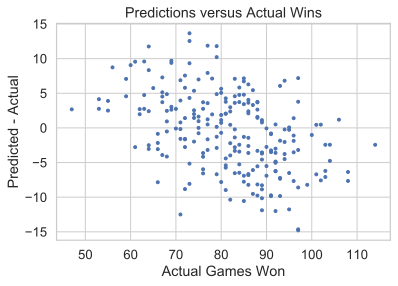

In [59]:
plt.title('Predictions versus Actual Wins')
plt.xticks()
plt.xlabel('Actual Games Won')
plt.ylabel('Predicted - Actual')
plt.plot(wins_test, win_diff, '.');

# Experiment Polynomial

In [60]:
from sklearn.preprocessing import PolynomialFeatures

p = PolynomialFeatures()
features_poly = p.fit_transform(features_train)
features_val_poly = p.fit_transform(features_val)
features_test_poly = p.fit_transform(features_test)

lr_full = LinearRegression()
model = lr_full.fit(features_poly, wins_train)
lr_full.score(features_val_poly, wins_val)

0.8290030660092301

In [61]:
test_wins = model.predict(features_test_poly)
win_diff = test_wins - wins_test
win_diff.abs().describe()

count    230.000000
mean       4.054508
std        2.908645
min        0.012031
25%        1.705011
50%        3.481382
75%        5.808864
max       12.799880
Name: W, dtype: float64

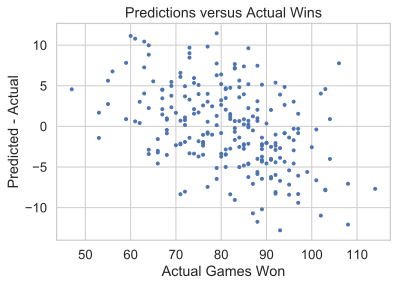

In [62]:
plt.title('Predictions versus Actual Wins')
plt.xticks()
plt.xlabel('Actual Games Won')
plt.ylabel('Predicted - Actual')
plt.plot(wins_test, win_diff, '.');

# Bucket by league

In [63]:
features = pd.get_dummies(all_games[['Lg'] + combined_features_noba])
wins = all_games['W']

features, features_test, wins, wins_test = train_test_split(features, wins, test_size=.2, random_state=10)
features_train, features_val, wins_train, wins_val = train_test_split(features, wins, test_size=.25, random_state=3)

In [64]:
# create the model
lr = LinearRegression()
model = lr.fit(features_train, wins_train)

In [65]:
lr.score(features_val, wins_val)

0.8278921928849787

In [66]:
lr.coef_

array([ 3.06961946e+02,  1.50193975e+02, -3.40806256e+02, -1.41815177e+02,
        1.00348362e-01, -1.00348362e-01])

In [67]:
test_wins = model.predict(features_test)
win_diff = test_wins - wins_test
win_diff.abs().describe()

count    230.000000
mean       4.015492
std        2.892958
min        0.004871
25%        1.825901
50%        3.490067
75%        5.880832
max       13.155058
Name: W, dtype: float64

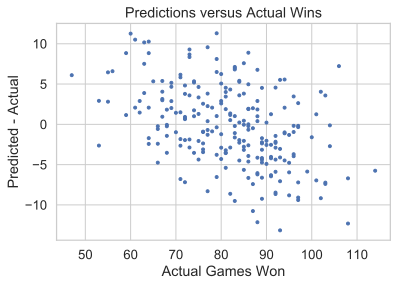

In [68]:
plt.title('Predictions versus Actual Wins')
plt.xticks()
plt.xlabel('Actual Games Won')
plt.ylabel('Predicted - Actual')
plt.plot(wins_test, win_diff, '.');

# Using Lasso

In [142]:
features = all_games[combined_features_noba]
std = StandardScaler()
std.fit(features)
scaled_features = std.transform(features)
wins = all_games['W']


lasso_model = LassoCV(cv=3, n_alphas=1000)
lasso_model.fit(scaled_features, wins)

LassoCV(alphas=None, copy_X=True, cv=3, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=1000, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [143]:
lasso_model.alpha_

0.013440022466707157

In [144]:
features, features_test, wins, wins_test = train_test_split(features, wins, test_size=.2, random_state=10)
features_train, features_val, wins_train, wins_val = train_test_split(features, wins, test_size=.25, random_state=3)

std.fit(features_train)
scaled_features_train = std.transform(features_train)

std.fit(features_val)
scaled_features_val = std.transform(features_val)

std.fit(features_test)
scaled_features_test = std.transform(features_test)

lasso_model = Lasso(alpha = 0.015) # this is a VERY HIGH regularization strength!, wouldn't usually be used
lasso_model.fit(scaled_features_train, wins_train)

Lasso(alpha=0.015, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [145]:
lasso_model.score(scaled_features_val, wins_val)

0.8065410790499781

In [146]:
test_wins = lasso_model.predict(scaled_features_test)
win_diff = test_wins - wins_test
win_diff.abs().describe()

count    230.000000
mean       4.133847
std        2.890082
min        0.226582
25%        1.876013
50%        3.582086
75%        5.773554
max       13.473958
Name: W, dtype: float64

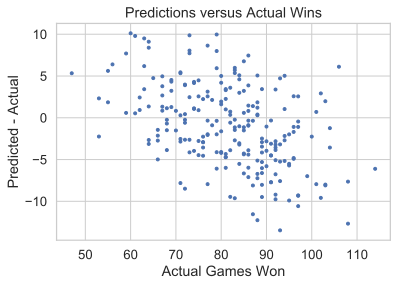

In [147]:
plt.title('Predictions versus Actual Wins')
plt.xticks()
plt.xlabel('Actual Games Won')
plt.ylabel('Predicted - Actual')
plt.plot(wins_test, win_diff, '.');

# Using deviations

In [169]:
full_avgs_df

Year Team       Lg   W    G     BA    OBP    SLG   BA_A  OBP_A  SLG_A
0     2020  ARI  NL West  25   60  0.241  0.312  0.391  0.253  0.336  0.462
1     2019  ARI  NL West  85  162  0.252  0.323  0.434  0.251  0.320  0.432
2     2018  ARI  NL West  82  162  0.235  0.310  0.397  0.239  0.310  0.388
3     2017  ARI  NL West  93  162  0.254  0.329  0.445  0.240  0.309  0.398
4     2016  ARI  NL West  69  162  0.261  0.320  0.432  0.275  0.348  0.454
...    ...  ...      ...  ..  ...    ...    ...    ...    ...    ...    ...
1767  1973  WSN  NL East  79  162  0.251  0.340  0.364  0.250  0.334  0.371
1768  1972  WSN  NL East  70  156  0.234  0.303  0.325  0.245  0.321  0.351
1769  1971  WSN  NL East  71  162  0.246  0.322  0.343  0.261  0.341  0.388
1770  1970  WSN  NL East  73  162  0.237  0.323  0.365  0.261  0.349  0.407
1771  1969  WSN  NL East  52  162  0.240  0.310  0.359  0.263  0.350  0.395

[1772 rows x 11 columns]

In [173]:
full_avgs_df['OBP_Dev'] = full_avgs_df['OBP']/full_avgs_df['OBP'].groupby(full_avgs_df['Year']).transform('mean')
full_avgs_df['SLG_Dev'] = full_avgs_df['SLG']/full_avgs_df['SLG'].groupby(full_avgs_df['Year']).transform('mean')
full_avgs_df['OBP_A_Dev'] = full_avgs_df['OBP_A']/full_avgs_df['OBP_A'].groupby(full_avgs_df['Year']).transform('mean')
full_avgs_df['SLG_A_Dev'] = full_avgs_df['SLG_A']/full_avgs_df['SLG_A'].groupby(full_avgs_df['Year']).transform('mean')
full_avgs_df

Year Team       Lg   W    G     BA    OBP    SLG   BA_A  OBP_A  SLG_A  \
0     2020  ARI  NL West  25   60  0.241  0.312  0.391  0.253  0.336  0.462   
1     2019  ARI  NL West  85  162  0.252  0.323  0.434  0.251  0.320  0.432   
2     2018  ARI  NL West  82  162  0.235  0.310  0.397  0.239  0.310  0.388   
3     2017  ARI  NL West  93  162  0.254  0.329  0.445  0.240  0.309  0.398   
4     2016  ARI  NL West  69  162  0.261  0.320  0.432  0.275  0.348  0.454   
...    ...  ...      ...  ..  ...    ...    ...    ...    ...    ...    ...   
1767  1973  WSN  NL East  79  162  0.251  0.340  0.364  0.250  0.334  0.371   
1768  1972  WSN  NL East  70  156  0.234  0.303  0.325  0.245  0.321  0.351   
1769  1971  WSN  NL East  71  162  0.246  0.322  0.343  0.261  0.341  0.388   
1770  1970  WSN  NL East  73  162  0.237  0.323  0.365  0.261  0.349  0.407   
1771  1969  WSN  NL East  52  162  0.240  0.310  0.359  0.263  0.350  0.395   

       OBP_Dev   SLG_Dev  OBP_A_Dev  SLG_A_Dev  
0     0.970049  0.937875   1.045535   1.107294  
1     1.001757  0.998466   0.992864   0.994246  
2     0.974945  0.970107   0.975149   0.948037  
3     1.014388  1.044846   0.952919   0.934931  
4     0.995644  1.035226   1.082875   1.088468  
...        ...       ...        ...        ...  
1767  1.046020  0.961691   1.028352   0.979969  
1768  0.976107  0.919269   1.034511   0.992694  
1769  1.017110  0.939512   1.076984   1.063499  
1770  0.992192  0.947027   1.072059   1.056343  
1771  0.969129  0.973229   1.094320   1.070098  

[1772 rows x 15 columns]

In [184]:
all_games_with_dev= full_avgs_df[full_avgs_df["G"] == 162]
only_devs = ['OBP_Dev', 'SLG_Dev', 'OBP_A_Dev', 'SLG_A_Dev']
combined_with_devs = ['OBP', 'OBP_Dev','SLG', 'SLG_Dev', 'OBP_A', 'OBP_A_Dev', 'SLG_A', 'SLG_A_Dev']

In [207]:
features = all_games_with_dev[combined_with_devs]
wins = all_games_with_dev['W']

In [199]:
features, features_test, wins, wins_test = train_test_split(features, wins, test_size=.2, random_state=10)
features_train, features_val, wins_train, wins_val = train_test_split(features, wins, test_size=.25, random_state=3)

In [200]:
# create the model
lr = LinearRegression()
model = lr.fit(features_train, wins_train)

In [201]:
lr.score(features_val, wins_val)

0.8285546928264467

In [202]:
lr.coef_

array([ 787.25778313, -156.48606614,   11.65036419,   55.49813573,
       -817.93133549,  155.92519659,   -2.62037096,  -57.16472195])

In [203]:
# run the model on our test set... we can see we are off by an average of 4 wins, and 75% of our predictions are within 6 wins
test_wins = model.predict(features_test)
win_diff = test_wins - wins_test
win_diff.abs().describe()

count    230.000000
mean       4.035759
std        2.871044
min        0.043944
25%        1.805535
50%        3.377040
75%        5.997038
max       13.049957
Name: W, dtype: float64

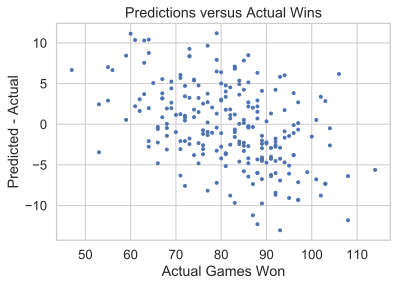

In [204]:
plt.title('Predictions versus Actual Wins')
plt.xticks()
plt.xlabel('Actual Games Won')
plt.ylabel('Predicted - Actual')
plt.plot(wins_test, win_diff, '.');

In [215]:
model = test_model(features, wins)

In [220]:
model["Score"]
model["Predicted_Values"] - model["Target_Values"]
model["Feature_Names"]
model["Coefficients"];